In [1]:
import os
import json
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [2]:
# Load the API key and set the model name
file_path = "../keys.json"
with open(file_path, "r", encoding="utf-8") as file:
    key_data = json.load(file)

os.environ["OPENAI_API_KEY"] = key_data["openai_api_key"]
model_name = "gpt-4o-mini"

llm = ChatOpenAI(temperature=0, model_name=model_name)


In [3]:
# Load the dataset JSON file
data_path = "../data/tqa_train_val_test/train/tqa_v1_train.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# For a quick check, print the first record
print(data[0])

{'adjunctTopics': {'Apply Concepts': {'content': {'figures': [], 'mediaLinks': [], 'text': '5. A glacier is melting. What are all of the scientists you can think of who might be involved in studying this glacier? What would each of them do? '}, 'orderID': 't_12'}, 'Introduction': {'content': {'figures': [{'caption': 'FIGURE 1.10 Earth as seen from Apollo 17.', 'imagePath': 'textbook_images/earth_science_and_its_branches_20010.png'}], 'mediaLinks': [], 'text': 'Earth Science is the study of all aspects of our planet Earth. Earth Science is not just about the molten lava, icy mountain peaks, steep canyons and towering waterfalls of the continents. Earth Science includes the atmosphere and oceans. The field also looks out into the solar system, galaxy, and universe. Earth scientists seek to understand the beautiful planet on which we depend (Figure 1.10). Different branches of Earth Science study one particular part of Earth. Since all of the branches are connected, specialists work toget

In [4]:
def extract_textbook_text(entry):
    """
    Extract textbook text from a TQA dataset entry.
    Retrieves text from the 'adjunctTopics' and 'topics' sections.
    """
    texts = []
    
    # Extract text from adjunctTopics
    adjunct_topics = entry.get("adjunctTopics", {})
    for topic in adjunct_topics.values():
        content = topic.get("content", {})
        text = content.get("text", "")
        if text:
            texts.append(text.strip())
            
    # Extract text from topics
    topics = entry.get("topics", {})
    for topic in topics.values():
        content = topic.get("content", {})
        text = content.get("text", "")
        if text:
            texts.append(text.strip())
    
    return texts

In [5]:
import os

def extract_textbook_text_with_image_explainations(entry):
    """
    Extract textbook text from a TQA dataset entry.
    Retrieves text from:
      - 'lessonName'
      - 'adjunctTopics' and their content text and figures (with LLava explanations)
      - 'topics' and their content text and figures (with LLava explanations)
    
    For figures, this function assumes that:
      - Figures with image paths containing "textbook_images" have their LLava explanations 
        stored in the "textbook_images_llava_captions" folder.
      - Figures with image paths containing "teaching_images" have their LLava explanations 
        stored in the "teaching_images_llava_captions" folder.
    
    Explanation files are assumed to be named as the image file name (without its extension)
    plus a ".txt" extension, and are located under the base directory:
    "../data/tqa_train_val_test/train/"
    """
    texts = []
    
    # Include lesson title
    lesson_name = entry.get("lessonName", "")
    if lesson_name:
        texts.append(f"Lesson: {lesson_name.strip()}")
    
    # Base directory for explanation files
    base_dir = "../data/tqa_train_val_test/train/"
    
    def extract_content_and_explanations(section):
        section_texts = []
        content = section.get("content", {})
        
        # Append the text content if available
        text = content.get("text", "")
        if text:
            section_texts.append(text.strip())
        
        # Process figures for captions and explanations
        figures = content.get("figures", [])
        for fig in figures:
            caption = fig.get("caption", "").strip()
            image_path = fig.get("imagePath", "")
            if image_path:
                # Determine the appropriate explanation folder based on the image path
                if "textbook_images" in image_path:
                    explanation_folder = "textbook_images_llava_captions"
                elif "teaching_images" in image_path:
                    explanation_folder = "teaching_images_llava_captions"
                else:
                    explanation_folder = None
                
                if explanation_folder:
                    file_name = os.path.basename(image_path)
                    # Remove file extension and add .txt
                    base_name = os.path.splitext(file_name)[0]
                    explanation_file = os.path.join(base_dir, explanation_folder, base_name + ".txt")
                    print("Looking for explanation file:", explanation_file)
                    if os.path.exists(explanation_file):
                        with open(explanation_file, 'r') as f:
                            explanation = f.read().strip()
                        if explanation:
                            # Combine caption and explanation in a single string
                            combined_text = ""
                            if caption:
                                combined_text += f"Image Caption: {caption}. "
                            combined_text += f"Image Explanation: {explanation}"
                            section_texts.append(combined_text)
        return section_texts

    # Extract text and explanations from adjunctTopics
    adjunct_topics = entry.get("adjunctTopics", {})
    for topic in adjunct_topics.values():
        texts.extend(extract_content_and_explanations(topic))
    
    # Extract text and explanations from topics
    topics = entry.get("topics", {})
    for topic in topics.values():
        texts.extend(extract_content_and_explanations(topic))
    
    return texts


In [6]:
# Combine the extracted text from the first record
extracted_texts = extract_textbook_text_with_image_explainations(data[0])
combined_text = "\n\n".join(extracted_texts)
print("Combined Text:\n")
print(combined_text)

Looking for explanation file: ../data/tqa_train_val_test/train/textbook_images_llava_captions/earth_science_and_its_branches_20010.txt
Looking for explanation file: ../data/tqa_train_val_test/train/textbook_images_llava_captions/earth_science_and_its_branches_20017.txt
Looking for explanation file: ../data/tqa_train_val_test/train/textbook_images_llava_captions/earth_science_and_its_branches_20011.txt
Looking for explanation file: ../data/tqa_train_val_test/train/textbook_images_llava_captions/earth_science_and_its_branches_20012.txt
Looking for explanation file: ../data/tqa_train_val_test/train/textbook_images_llava_captions/earth_science_and_its_branches_20013.txt
Looking for explanation file: ../data/tqa_train_val_test/train/textbook_images_llava_captions/earth_science_and_its_branches_20014.txt
Looking for explanation file: ../data/tqa_train_val_test/train/textbook_images_llava_captions/earth_science_and_its_branches_20015.txt
Looking for explanation file: ../data/tqa_train_val_tes

In [7]:
########################
# 1. Generate Mindmap  #
########################
def generate_mindmap(text, llm, max_tokens=300):
    """
    Generate a mind map in Mermaid syntax for the given text using ChatOpenAI (or similar LLM).
    The mind map should capture the main topics and their subtopics in a clear hierarchical structure.
    IMPORTANT: We instruct the model not to use a generic 'root' node, but rather a relevant main topic
    as the central node for better readability.
    """
    prompt = (
        "Generate a mind map in Mermaid syntax for the following textbook text. "
        "The mind map should capture the main topics and their subtopics clearly in a hierarchical structure. "
        "Do NOT include a 'root' node; instead, use a relevant central topic. "
        "The mind map should be self-explanatory so that by reading it, a user can understand the key content and structure "
        "of the text document. Keep the Mermaid syntax minimal so it renders correctly, and be concise.\n\n"
        f"{text}\n\n"
        "Mermaid Mind Map:"
    )
    
    result = llm.invoke(prompt, max_tokens=max_tokens)
    mindmap = result.content.strip()
    return mindmap

In [8]:
############################
# 2. Clean Mermaid Code    #
############################
def clean_mermaid_code(code):
    """
    Remove ```mermaid code fences or other markdown backticks.
    Ensures the CLI sees only valid Mermaid syntax.
    """
    lines = code.splitlines()
    # Remove lines that start with ```
    lines = [line for line in lines if not line.strip().startswith("```")]
    return "\n".join(lines)

In [9]:
from IPython.display import SVG, display
import subprocess
import os

def render_mermaid(mindmap_code, output_filename='mermaid_output.svg', theme='neutral', background_color=None, css_file=None):
    """
    Render a Mermaid diagram as an SVG file using the Mermaid CLI (mmdc).
    
    Parameters:
    - mindmap_code: Mermaid syntax code to render.
    - output_filename: Name of the output SVG file.
    - theme: Mermaid theme to use (e.g., 'forest', 'dark', 'neutral').
    - background_color: Optional background color (e.g., "#ffffff").
    - css_file: Optional path to a custom CSS file for additional styling.
    
    The function writes the Mermaid code to a temporary file, invokes the Mermaid CLI,
    displays the generated SVG inline (Jupyter/IPython), and cleans up temporary files.
    """
    # Write Mermaid code to a temporary file
    temp_file = "temp_mermaid.mmd"
    with open(temp_file, "w", encoding="utf-8") as f:
        f.write(mindmap_code)
    
    # Build the command for Mermaid CLI
    cmd = ["mmdc", "-i", temp_file, "-o", output_filename, "-t", theme]
    
    if background_color:
        cmd.extend(["-b", background_color])
    
    if css_file:
        cmd.extend(["-c", css_file])
    
    subprocess.run(cmd, check=True)
    
    # Display the generated SVG inline (Jupyter/IPython)
    display(SVG(output_filename))
    
    os.remove(temp_file)


In [10]:
# Generate the Mermaid mind map for the combined textbook text
mindmap_code = generate_mindmap(combined_text, llm)
print("\nGenerated Mind Map (Mermaid format):\n")
print(mindmap_code)


Generated Mind Map (Mermaid format):

```mermaid
mindmap
  Earth Science
    Definition
      Study of Earth's aspects
      Includes atmosphere and oceans
      Explores solar system and universe
    Branches
      Geology
        Study of rocks and minerals
        Processes of Earth
        Specializations
          Mineralogy
          Volcanology
          Seismology
          Paleontology
          Planetary geology
      Oceanography
        Study of oceans
        Water movement and chemistry
        Specializations
          Physical oceanography
          Marine geology
          Chemical oceanography
          Marine biology
      Meteorology
        Study of atmosphere
        Weather patterns and climate
        Importance of forecasting
        Climatology
      Environmental Science
        Human impact on environment
        Ecological studies
      Astronomy
        Study of solar system and universe
        Tools and methods
        Questions about existence and reso

Cleaned Mermaid code:
mindmap
  Earth Science
    Definition
      Study of Earth's aspects
      Includes atmosphere and oceans
      Explores solar system and universe
    Branches
      Geology
        Study of rocks and minerals
        Processes of Earth
        Specializations
          Mineralogy
          Volcanology
          Seismology
          Paleontology
          Planetary geology
      Oceanography
        Study of oceans
        Water movement and chemistry
        Specializations
          Physical oceanography
          Marine geology
          Chemical oceanography
          Marine biology
      Meteorology
        Study of atmosphere
        Weather patterns and climate
        Importance of forecasting
        Climatology
      Environmental Science
        Human impact on environment
        Ecological studies
      Astronomy
        Study of solar system and universe
        Tools and methods
        Questions about existence and resources
    Importance
      U

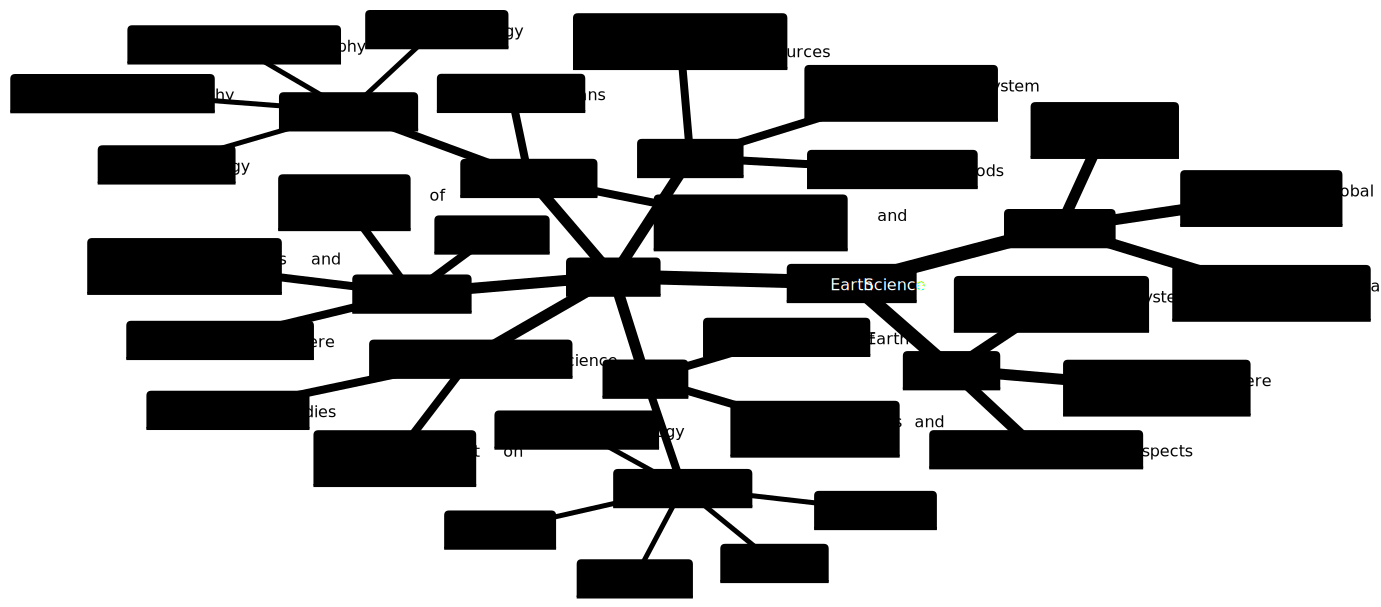

In [11]:

# 2) Clean code to remove markdown fences
cleaned_code = clean_mermaid_code(mindmap_code)
print("Cleaned Mermaid code:")
print(cleaned_code)

# 3) Render with the desired theme (e.g., 'forest', 'dark', 'neutral')
render_mermaid(cleaned_code, 'mermaid_output.svg', theme='forest')